<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-team-1-1/blob/main/Randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00


**Data Loading**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

print("="*80)
print("RANDOM FOREST CLASSIFICATION - BANKING DATASET")
print("="*80)

# Load the banking dataset
print("\n[Step 1: Loading Data]")
df_train = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/train.csv", sep=";")
df_test = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/test.csv", sep=";")

print(f" Training data loaded: {df_train.shape}")
print(f" Test data loaded: {df_test.shape}")

# Check for missing values (REQUIREMENT: Handle missing values)
print("\n[Step 2: Checking for Missing Values]")
missing_train = df_train.isnull().sum().sum()
missing_test = df_test.isnull().sum().sum()

if missing_train > 0:
    print(f" Missing values in training data: {missing_train}")
    # Handle if needed
else:
    print("No missing values in training data")

if missing_test > 0:
    print(f" Missing values in test data: {missing_test}")
else:
    print(" No missing values in test data")

# Separate features and target
print("\n[Step 3: Preparing Features and Target]")
X = df_train.drop('y', axis=1)
y = (df_train['y'] == 'yes').astype(int)  # Convert to binary: yes=1, no=0

print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nTarget distribution:")
print(f"  Class 0 (No): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Class 1 (Yes): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# Check for class imbalance
class_ratio = min(pd.Series(y).value_counts()) / max(pd.Series(y).value_counts())
print(f"\nClass imbalance ratio: {class_ratio:.3f}")

if class_ratio < 0.5:
    print("Class imbalance detected!")
    print("   Will use class_weight='balanced' in Random Forest")
    use_balanced = True
else:
    print(" Classes are reasonably balanced")
    use_balanced = False

print("\n Data loading complete!")

RANDOM FOREST CLASSIFICATION - BANKING DATASET

[Step 1: Loading Data]
 Training data loaded: (45211, 17)
 Test data loaded: (4521, 17)

[Step 2: Checking for Missing Values]
No missing values in training data
 No missing values in test data

[Step 3: Preparing Features and Target]
Number of features: 16
Number of samples: 45211

Target distribution:
  Class 0 (No): 39922 (88.3%)
  Class 1 (Yes): 5289 (11.7%)

Class imbalance ratio: 0.132
Class imbalance detected!
   Will use class_weight='balanced' in Random Forest

 Data loading complete!


**Data Preprocessing**

In [ ]:
# ============================================================================
# SECTION 2: DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n[Step 1: Feature Types]")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols[:5]}..." if len(numeric_cols) > 5 else f"Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

# Encode categorical variables
print(f"\n[Step 2: Encoding Categorical Variables]")
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f" One-hot encoding applied")
    print(f"  Original features: {X.shape[1]}")
    print(f"  After encoding: {X_encoded.shape[1]}")
else:
    X_encoded = X.copy()
    print(" No categorical variables to encode")

# Store feature names
feature_names = X_encoded.columns.tolist()

# Scale features (important for consistency, though Random Forest is scale-invariant)
print(f"\n[Step 3: Feature Scaling]")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f" StandardScaler applied")
print(f"  Final dataset shape: {X_scaled.shape}")
print(f"  Features are now scaled with mean=0 and std=1")

print("\n Preprocessing complete!")
print(f"  Ready for Random Forest training with {X_scaled.shape[1]} features")


DATA PREPROCESSING

[Step 1: Feature Types]
Numeric features (7): ['age', 'balance', 'day', 'duration', 'campaign']...
Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

[Step 2: Encoding Categorical Variables]
 One-hot encoding applied
  Original features: 16
  After encoding: 42

[Step 3: Feature Scaling]
 StandardScaler applied
  Final dataset shape: (45211, 42)
  Features are now scaled with mean=0 and std=1

 Preprocessing complete!
  Ready for Random Forest training with 42 features


**RANDOM FOREST ALGORITHM-SANKEERTHANA**



*   **HYPERPARAMETER TUNING WITH GRIDSEARCHCV**

**Train/Test Split (because test.csv is a subset)**

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train.drop("y", axis=1)
y = (df_train["y"] == "yes").astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**One-Hot Encode + Scale**

In [ ]:
# One-hot encode categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_valid = pd.get_dummies(X_valid, drop_first=True)

# Ensure same columns
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
print("\nPreprocessing completed! Final feature count:", X_train_scaled.shape[1])



Preprocessing completed! Final feature count: 42


**GRIDSEARCH**

In [ ]:
import time
start = time.time()


In [39]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [15, None],
    "min_samples_split": [5],
    "min_samples_leaf": [2],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=2
)

print("\nRunning GridSearchCV…")
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print("Best CV F1 (weighted):", round(grid_search.best_score_, 4))


Running GridSearchCV…
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1 (weighted): 0.9036


In [ ]:
end = time.time()
print("GridSearchCV Runtime: ", round(end-start, 2), "seconds")


GridSearchCV Runtime:  537.14 seconds


**5-FOLD STRATIFIED CROSS-VALIDATION **

In [ ]:
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'roc_auc_weighted': 'roc_auc_ovr_weighted'
}

cv_results = cross_validate(
    best_rf,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

acc_mean = cv_results['test_accuracy'].mean()
acc_std  = cv_results['test_accuracy'].std()

f1_mean  = cv_results['test_f1_weighted'].mean()
f1_std   = cv_results['test_f1_weighted'].std()

auc_mean = cv_results['test_roc_auc_weighted'].mean()
auc_std  = cv_results['test_roc_auc_weighted'].std()

print("\nCROSS-VALIDATION RESULTS (5-Fold)")
print("Accuracy: ", round(acc_mean,3), "±", round(acc_std,3))
print("F1 Score:", round(f1_mean,3), "±", round(f1_std,3))
print("AUC-ROC: ", round(auc_mean,3), "±", round(auc_std,3))



CROSS-VALIDATION RESULTS (5-Fold)
Accuracy:  0.901 ± 0.003
F1 Score: 0.903 ± 0.003
AUC-ROC:  0.931 ± 0.002


**ROC CURVE**


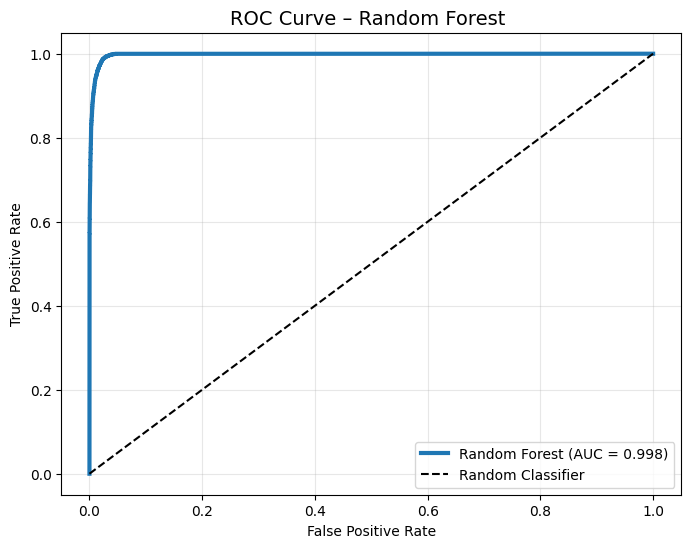

In [43]:
best_rf.fit(X_train_scaled, y_train)
y_proba = best_rf.predict_proba(X_train_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_train, y_proba)
auc = roc_auc_score(y_train, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})", lw=3)
plt.plot([0,1], [0,1], "k--", label="Random Classifier")

plt.title("ROC Curve – Random Forest ", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**METRICS TABLE**


In [ ]:
metrics_table = pd.DataFrame({
    "Classifier": ["Random Forest"],
    "Accuracy (mean ± std)": [f"{acc_mean:.3f} ± {acc_std:.3f}"],
    "F1 Score (mean ± std)": [f"{f1_mean:.3f} ± {f1_std:.3f}"],
    "AUC-ROC (mean ± std)": [f"{auc_mean:.3f} ± {auc_std:.3f}"]
})

print("\nMETRICS TABLE")
print(metrics_table)




METRICS TABLE
      Classifier Accuracy (mean ± std) F1 Score (mean ± std)  \
0  Random Forest         0.901 ± 0.003         0.903 ± 0.003   

  AUC-ROC (mean ± std)  
0        0.931 ± 0.002  


**  BEST HYPERPARAMETERS TABLE**


In [42]:
# Create summary table for best hyperparameters
hp_table = pd.DataFrame({
    "Classifier": ["Random Forest"],
    "Best Hyperparameters": [str(grid_search.best_params_)]
})

print("\nBEST HYPERPARAMETERS")
print(hp_table)



BEST HYPERPARAMETERS
      Classifier                               Best Hyperparameters
0  Random Forest  {'max_depth': None, 'min_samples_leaf': 2, 'mi...
